# 날씨에 민감한 상품군 파악

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd 
import numpy as np
pd.set_option("max_rows", 500)
pd.set_option("max_columns", 500)
pd.set_option('float_format', '{:f}'.format)

import dataload

import os 
import datetime
from tqdm import tqdm 
from functools import reduce

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('seaborn')
plt.rc('font', family='AppleGothic')
plt.rc('axes', unicode_minus=False)

In [3]:
weather = pd.read_csv('weather_final2.csv', encoding='cp949')
weatherindex = pd.read_csv('data_with_weather.csv', encoding='cp949')
search = pd.read_csv('trend_with_weather.csv', encoding='cp949')

weather.shape, weatherindex.shape, search.shape

((11680, 29), (2056899, 18), (2568668, 12))

In [4]:
weather = weather.drop(['연', '월', '일', '분기', '요일', '공휴일명', '공휴일여부', '주말여부', '계절', '폭염여부', '강수여부', 'year', 'month'], axis=1)
weather.shape

(11680, 16)

In [5]:
weather.shape[0] == weather.날짜.nunique() * weather.지역.nunique()

True

In [6]:
weather = weather.rename(columns = {'날짜':'date'})

In [7]:
weather.head()

,date,지점번호,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,지역,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수
0,2018-01-01,105,1.300000,5.700000,-2.100000,0.000000,0.000000,3.700000,강릉,20.066667,13.400000,25.400000,57.900000,1023.000000,7.502056,-39.701524
1,2018-01-01,112,-0.300000,2.700000,-2.700000,0.000000,0.000000,1.600000,인천,37.518681,18.641758,67.200000,53.800000,1020.300000,9.992379,-42.924922
2,2018-01-01,119,-1.700000,4.700000,-6.900000,0.000000,0.000000,1.000000,수원,42.782895,21.375000,84.700000,52.700000,1025.100000,10.136402,-45.791893
3,2018-01-01,136,-1.000000,4.700000,-6.500000,0.000000,0.000000,2.200000,안동,39.750000,28.583333,56.400000,58.300000,1010.600000,8.356692,-44.375704
4,2018-01-01,152,2.100000,6.200000,-0.400000,0.000000,0.000000,3.300000,울산,38.548193,15.433735,42.800000,58.300000,1017.100000,8.861429,-38.064334


In [8]:
weather[weather["지역"]=="서울"].corr(method="spearman")[1:]

,지점번호,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수
평균기온,nan,1.000000,0.988062,0.989422,0.200475,0.204471,-0.168313,-0.385256,-0.264429,0.341613,0.105389,-0.852687,0.996995,0.999991
최고기온,nan,0.988062,1.000000,0.961493,0.117286,0.122748,-0.180586,-0.336675,-0.223889,0.276356,0.209514,-0.827547,0.986202,0.987851
최저기온,nan,0.989422,0.961493,1.000000,0.268868,0.271990,-0.151177,-0.416671,-0.289416,0.399006,0.016113,-0.860640,0.985683,0.989602
일별강수량,nan,0.200475,0.117286,0.268868,1.000000,0.984517,0.006665,-0.321709,-0.254290,0.681903,-0.538949,-0.321077,0.191128,0.202219
1시간최대강수량,nan,0.204471,0.122748,0.271990,0.984517,1.000000,0.004830,-0.325075,-0.254256,0.683915,-0.528536,-0.321492,0.195335,0.206230
평균풍속,nan,-0.168313,-0.180586,-0.151177,0.006665,0.004830,1.000000,-0.050372,-0.154974,-0.060766,0.133846,0.041644,-0.229493,-0.168211
PM10,nan,-0.385256,-0.336675,-0.416671,-0.321709,-0.325075,-0.050372,1.000000,0.915318,-0.191871,0.041426,0.292665,-0.378371,-0.385453
PM25,nan,-0.264429,-0.223889,-0.289416,-0.254290,-0.254256,-0.154974,0.915318,1.000000,-0.063839,-0.038064,0.200452,-0.250976,-0.264413
1시간최대습도,nan,0.341613,0.276356,0.399006,0.681903,0.683915,-0.060766,-0.191871,-0.063839,1.000000,-0.416204,-0.418230,0.334354,0.343931
일조시간합,nan,0.105389,0.209514,0.016113,-0.538949,-0.528536,0.133846,0.041426,-0.038064,-0.416204,1.000000,-0.010232,0.097105,0.104069


In [9]:
buy_full = dataload.load_buy()
print(buy_full.shape)
buy_full.head()

(2056899, 6)


,date,sex,age,big_cat,sm_cat,qty
0,20180101,F,20,식품,가공란,37
1,20180101,F,30,식품,가공란,16
2,20180101,F,40,식품,가공란,9
3,20180101,F,50,식품,가공란,3
4,20180101,M,20,식품,가공란,13


In [10]:
tqdm.pandas()
weather["date"] = weather["date"].progress_apply(lambda x : pd.to_datetime(str(x), format="%Y-%m-%d"))
buy_full["date"] = buy_full["date"].progress_apply(lambda x : pd.to_datetime(str(x), format="%Y-%m-%d"))

100%|██████████| 2056899/2056899 [02:39<00:00, 12867.25it/s]


In [11]:
buy = buy_full.groupby(['date', 'sm_cat']).sum('qty').reset_index()[["sm_cat", "date", "qty"]]
buy.shape

(267707, 3)

## 1. Correlation 기준 체크 
* 지역 설정 필요! 

In [12]:
def weather_correlation(product, loc) : 
    df1 = weather[weather.지역 == loc].reset_index(drop=True)
    df2 = buy[buy.sm_cat == product]
    df = df1.merge(df2, on="date", how='left')
    df['sm_cat'] = df['sm_cat'].fillna(product) ; df['qty'] = df['qty'].fillna(0)
    co = np.abs(df.corr(method='spearman')["qty"][1:-1])
    return sum(co)

In [17]:
weather_correlation('감귤/한라봉/오렌지', '서울')

6.200597677785387

In [15]:
result = pd.DataFrame({
    'category' : buy.sm_cat.unique()
})

result["correlation"] = result["category"].progress_apply(lambda x : weather_correlation(x, '서울'))

100%|██████████| 383/383 [00:07<00:00, 48.03it/s]


In [16]:
result.sort_values('correlation', ascending=False).head(30)

,category,correlation
287,초음파식 가습기,6.373866
156,복합식 가습기,6.293211
7,감귤/한라봉/오렌지,6.200598
48,굴 생물,6.134065
238,에어워셔,5.878635
237,업소용 선풍기,5.736088
330,해초류,5.639178
332,핸드크림,5.630654
161,뷰티 타투,5.622354
363,히터,5.610631


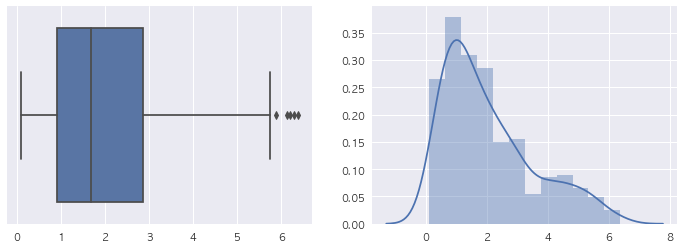

In [189]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4) 

sns.boxplot(result[["correlation"]], ax=ax1)
sns.distplot(result[["correlation"]], ax=ax2)

In [190]:
result.describe()

,correlation
count,383.000000
mean,2.049274
std,1.484052
min,0.094381
25%,0.908728
50%,1.679599
75%,2.852804
max,6.373866


In [192]:
buy_category = buy_full[["big_cat", 'sm_cat']].drop_duplicates().reset_index(drop=True)
buy_category = buy_category.merge(result, left_on='sm_cat', right_on="category", how='left')
buy_category.shape

(383, 4)

In [193]:
buy_category[buy_category["correlation"] > 1.5].shape

(201, 4)

In [194]:
buy_category[buy_category["correlation"] > 1.5].big_cat.value_counts()

식품       94
뷰티       72
냉난방가전    35
Name: big_cat, dtype: int64

## 2. 날씨 데이터 상세하게 체크하기 

In [25]:
buy[buy.sm_cat == '여성향수']

,sm_cat,date,qty
43406,여성향수,2018-04-29,1
54399,여성향수,2018-05-29,1
70857,여성향수,2018-07-13,1
87955,여성향수,2018-08-29,1
108756,여성향수,2018-10-25,1
115350,여성향수,2018-11-12,1
161243,여성향수,2019-03-17,1
193745,여성향수,2019-06-13,1
200009,여성향수,2019-06-30,1
236317,여성향수,2019-10-07,1


In [24]:
weather[weather.지역 == '서울'].reset_index(drop=True).merge(buy[buy.sm_cat == '여성향수'], on="date", how='left')

,date,지점번호,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,지역,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,sm_cat,qty
0,2018-01-04,108,-4.700000,-0.700000,-8.700000,0.000000,0.000000,1.400000,서울,46.385027,25.381462,57.000000,41.500000,1020.400000,7.234635,-52.095698,NaN,nan
1,2018-01-05,108,-3.000000,1.600000,-5.600000,0.000000,0.000000,1.700000,서울,57.841918,37.159858,56.900000,49.100000,1012.700000,7.839316,-48.525270,NaN,nan
2,2018-01-07,108,-0.800000,2.800000,-5.700000,0.000000,0.000000,0.800000,서울,55.337434,40.042179,61.200000,23.400000,1014.600000,11.126838,-43.958687,NaN,nan
3,2018-01-08,108,1.300000,4.000000,-1.200000,0.000000,0.000000,1.800000,서울,57.169912,40.598230,89.200000,3.500000,1007.500000,10.801840,-39.637946,NaN,nan
4,2018-01-11,108,-11.100000,-7.400000,-13.600000,0.000000,0.000000,2.800000,서울,32.776786,22.928571,62.300000,53.200000,1018.900000,-0.844125,-65.884972,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2019-12-21,108,-1.200000,1.500000,-5.100000,0.600000,0.300000,1.700000,서울,35.926486,24.071351,92.000000,13.900000,1019.900000,9.152142,-44.750760,NaN,nan
726,2019-12-24,108,0.800000,6.500000,-2.900000,0.000000,0.000000,1.400000,서울,71.260394,53.016411,87.900000,48.800000,1018.700000,11.141373,-40.655582,NaN,nan
727,2019-12-27,108,-1.700000,2.600000,-4.600000,0.000000,0.000000,2.100000,서울,35.617137,23.327549,64.000000,56.500000,1016.900000,8.016649,-45.813935,NaN,nan
728,2019-12-30,108,2.700000,6.800000,-5.700000,0.400000,0.500000,2.900000,서울,37.671010,25.619978,89.500000,0.000000,1018.400000,10.019105,-36.810104,NaN,nan


In [29]:
def weather_correlation2(product, loc) : 
    df1 = weather[weather.지역 == loc].reset_index(drop=True)
    df2 = buy[buy.sm_cat == product]
    df = df1.merge(df2, on="date", how='left')
    df['sm_cat'] = df['sm_cat'].fillna(product) ; df['qty'] = df['qty'].fillna(0)
    co = dict(np.abs(df.corr(method='spearman')["qty"][1:-1]))
    co["category"] = product
    return co

In [30]:
weather_correlation2('여성향수', '서울')

{'평균기온': 0.04154031615280878,
 '최고기온': 0.04119352528694497,
 '최저기온': 0.041967186413414674,
 '일별강수량': 0.013859733083079685,
 '1시간최대강수량': 0.01367135399605151,
 '평균풍속': 0.01085003531200246,
 'PM10': 0.02985433992788291,
 'PM25': 0.023237828487208234,
 '1시간최대습도': 0.03905909212122805,
 '일조시간합': 0.00747209797925452,
 '최고현지기압': 0.03689823356119712,
 '체감온도': 0.0422336320996635,
 '열지수': 0.04153995351621837,
 'category': '여성향수'}

In [32]:
pd.DataFrame(weather_correlation2('여성향수', '서울'), index=[0])

,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,category
0,0.041540,0.041194,0.041967,0.013860,0.013671,0.010850,0.029854,0.023238,0.039059,0.007472,0.036898,0.042234,0.041540,여성향수


In [196]:
result2 = pd.DataFrame()

for cat in tqdm(buy.sm_cat.unique()) : 
    result2 = result2.append(pd.DataFrame(weather_correlation2(cat, '서울'), index=[0]), ignore_index=True)

100%|██████████| 383/383 [00:08<00:00, 46.86it/s]


In [197]:
result2.head()

,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,category
0,0.009877,0.021020,0.001328,0.005753,0.010935,0.072498,0.120930,0.124314,0.012046,0.037676,0.041550,0.002262,0.009829,가공란
1,0.694533,0.681181,0.694446,0.233596,0.234399,0.064768,0.237118,0.148534,0.296310,0.052795,0.751439,0.688523,0.694727,가열식 가습기
2,0.170540,0.171172,0.175308,0.000188,0.007253,0.139302,0.096851,0.076179,0.022130,0.030031,0.129089,0.180686,0.170363,가자미
3,0.178182,0.154441,0.189870,0.120279,0.126110,0.050932,0.149490,0.100031,0.120812,0.136970,0.111733,0.170383,0.178458,갈비/찜/바비큐용 돈육
4,0.014486,0.009800,0.012349,0.024601,0.030742,0.085889,0.079819,0.052615,0.018723,0.061375,0.012293,0.008348,0.014452,갈비용 우육


In [198]:
buy_category2 = buy_full[["big_cat", 'sm_cat']].drop_duplicates().reset_index(drop=True)
buy_category2 = buy_category2.merge(result2, left_on='sm_cat', right_on="category", how='left')
buy_category2 = buy_category2.drop('category', axis=1)
buy_category2.shape

(383, 15)

In [199]:
buy_category2.head()

,big_cat,sm_cat,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수
0,식품,가공란,0.009877,0.021020,0.001328,0.005753,0.010935,0.072498,0.120930,0.124314,0.012046,0.037676,0.041550,0.002262,0.009829
1,냉난방가전,가열식 가습기,0.694533,0.681181,0.694446,0.233596,0.234399,0.064768,0.237118,0.148534,0.296310,0.052795,0.751439,0.688523,0.694727
2,식품,가자미,0.170540,0.171172,0.175308,0.000188,0.007253,0.139302,0.096851,0.076179,0.022130,0.030031,0.129089,0.180686,0.170363
3,식품,갈비/찜/바비큐용 돈육,0.178182,0.154441,0.189870,0.120279,0.126110,0.050932,0.149490,0.100031,0.120812,0.136970,0.111733,0.170383,0.178458
4,식품,갈비용 우육,0.014486,0.009800,0.012349,0.024601,0.030742,0.085889,0.079819,0.052615,0.018723,0.061375,0.012293,0.008348,0.014452


In [200]:
buy_category2["correlation"] = buy_category2.loc[:,list(buy_category2.columns)[2:]].sum(axis=1)

In [201]:
buy_category2.head()

,big_cat,sm_cat,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,correlation
0,식품,가공란,0.009877,0.021020,0.001328,0.005753,0.010935,0.072498,0.120930,0.124314,0.012046,0.037676,0.041550,0.002262,0.009829,0.470018
1,냉난방가전,가열식 가습기,0.694533,0.681181,0.694446,0.233596,0.234399,0.064768,0.237118,0.148534,0.296310,0.052795,0.751439,0.688523,0.694727,5.472369
2,식품,가자미,0.170540,0.171172,0.175308,0.000188,0.007253,0.139302,0.096851,0.076179,0.022130,0.030031,0.129089,0.180686,0.170363,1.369090
3,식품,갈비/찜/바비큐용 돈육,0.178182,0.154441,0.189870,0.120279,0.126110,0.050932,0.149490,0.100031,0.120812,0.136970,0.111733,0.170383,0.178458,1.787689
4,식품,갈비용 우육,0.014486,0.009800,0.012349,0.024601,0.030742,0.085889,0.079819,0.052615,0.018723,0.061375,0.012293,0.008348,0.014452,0.425492


In [202]:
buy_category2.sort_values(['평균기온', 'PM10', '일별강수량', 'correlation'], ascending=False).head(30)

,big_cat,sm_cat,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,correlation
287,냉난방가전,초음파식 가습기,0.819175,0.802823,0.818688,0.249171,0.249580,0.057451,0.315716,0.206995,0.323280,0.062754,0.837361,0.811464,0.819407,6.373866
156,냉난방가전,복합식 가습기,0.799613,0.781798,0.801828,0.247738,0.246761,0.070702,0.335301,0.234304,0.319788,0.060826,0.801455,0.793238,0.799858,6.293211
7,식품,감귤/한라봉/오렌지,0.781819,0.772209,0.779825,0.220087,0.224351,0.143872,0.339007,0.240850,0.264361,0.117065,0.754324,0.780989,0.781839,6.200598
48,식품,굴 생물,0.778428,0.769005,0.775915,0.209510,0.202766,0.091692,0.335131,0.259586,0.262712,0.121048,0.776070,0.773794,0.778408,6.134065
363,냉난방가전,히터,0.743829,0.734978,0.735393,0.200600,0.201550,0.070072,0.215728,0.116304,0.257924,0.077392,0.775258,0.737711,0.743890,5.610631
237,냉난방가전,업소용 선풍기,0.742508,0.732373,0.734911,0.207005,0.203186,0.060012,0.289943,0.184661,0.274205,0.101560,0.726278,0.736737,0.742709,5.736088
370,냉난방가전,탁상/USB 선풍기,0.740497,0.735811,0.729797,0.177454,0.174490,0.031198,0.209376,0.113882,0.248366,0.116136,0.751549,0.731666,0.740567,5.500790
238,냉난방가전,에어워셔,0.735215,0.717777,0.734148,0.240862,0.242960,0.080973,0.346412,0.243839,0.296342,0.042640,0.730367,0.731731,0.735368,5.878635
332,뷰티,핸드크림,0.731759,0.721303,0.726084,0.193824,0.193430,0.101470,0.258004,0.161740,0.245471,0.090728,0.746622,0.728325,0.731893,5.630654
161,뷰티,뷰티 타투,0.722963,0.719358,0.714999,0.177168,0.183630,0.080317,0.294297,0.197834,0.263440,0.125605,0.701808,0.717897,0.723038,5.622354


In [203]:
buy_category2.describe()

,평균기온,최고기온,최저기온,일별강수량,1시간최대강수량,평균풍속,PM10,PM25,1시간최대습도,일조시간합,최고현지기압,체감온도,열지수,correlation
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,0.249870,0.247704,0.247735,0.065854,0.067302,0.080325,0.118320,0.091320,0.085571,0.054952,0.241891,0.248566,0.249866,2.049274
std,0.204447,0.202430,0.202235,0.055696,0.055755,0.053475,0.093951,0.073999,0.073784,0.041940,0.210621,0.202497,0.204481,1.484052
min,0.001421,0.002400,0.000224,0.000029,0.000392,0.000666,0.001224,0.000592,0.000319,0.000730,0.000838,0.000232,0.001286,0.094381
25%,0.086267,0.085879,0.088158,0.020545,0.023135,0.036780,0.042375,0.034944,0.023711,0.021595,0.072169,0.085195,0.086287,0.908728
50%,0.188603,0.183763,0.192829,0.049055,0.051351,0.072902,0.093782,0.072543,0.069420,0.045784,0.174906,0.192136,0.188549,1.679599
75%,0.366753,0.368448,0.364458,0.101640,0.102295,0.114823,0.179307,0.135879,0.124436,0.076340,0.356827,0.363546,0.366750,2.852804
max,0.819175,0.802823,0.818688,0.290211,0.287352,0.254873,0.556420,0.449979,0.343261,0.189992,0.837361,0.811464,0.819407,6.373866


In [204]:
print("* 기온 *")
print(buy_category2[buy_category2['평균기온']>0.35].shape)
buy_category2[buy_category2['평균기온']>0.35].big_cat.value_counts()

* 기온 *
(106, 16)


식품       47
뷰티       30
냉난방가전    29
Name: big_cat, dtype: int64

# 3. 날씨 선별 
* '평균기온', '일별강수량', '평균풍속', 'PM10', '1시간최대습도', '일조시간합'

In [248]:
def weather_correlation3(weather, product, loc) : 
    df1 = weather[weather.지역 == loc].reset_index(drop=True)
    df2 = buy[buy.sm_cat == product]
    df = df1.merge(df2, on="date", how='left')
    df['sm_cat'] = df['sm_cat'].fillna(product) ; df['qty'] = df['qty'].fillna(0)
    co = dict(np.abs(df.corr(method='spearman')["qty"][:-1]))
    co["category"] = product
    return co

In [205]:
result3 = pd.DataFrame()
weather2 = weather[["date", "지역", '평균기온', '일별강수량', '평균풍속', 'PM10', '1시간최대습도', '일조시간합']]

for cat in tqdm(buy.sm_cat.unique()) : 
    result3 = result3.append(pd.DataFrame(weather_correlation3(weather2, cat, '서울'), index=[0]), ignore_index=True)
    
buy_category3 = buy_full[["big_cat", 'sm_cat']].drop_duplicates().reset_index(drop=True)
buy_category3 = buy_category3.merge(result3, left_on='sm_cat', right_on="category", how='left')
buy_category3 = buy_category3.drop('category', axis=1)

# score 
buy_category3["correlation"] = buy_category3.loc[:,list(buy_category3.columns)[2:]].sum(axis=1)

100%|██████████| 383/383 [00:07<00:00, 52.03it/s]


In [206]:
buy_category3.head()

,big_cat,sm_cat,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,correlation
0,식품,가공란,0.009877,0.005753,0.072498,0.120930,0.012046,0.037676,0.258780
1,냉난방가전,가열식 가습기,0.694533,0.233596,0.064768,0.237118,0.296310,0.052795,1.579120
2,식품,가자미,0.170540,0.000188,0.139302,0.096851,0.022130,0.030031,0.459041
3,식품,갈비/찜/바비큐용 돈육,0.178182,0.120279,0.050932,0.149490,0.120812,0.136970,0.756664
4,식품,갈비용 우육,0.014486,0.024601,0.085889,0.079819,0.018723,0.061375,0.284893


In [250]:
buy_category3.sort_values('correlation', ascending=False).head(10)

,big_cat,sm_cat,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,correlation
7,식품,감귤/한라봉/오렌지,0.781819,0.220087,0.143872,0.339007,0.264361,0.117065,1.866211
156,냉난방가전,복합식 가습기,0.799613,0.247738,0.070702,0.335301,0.319788,0.060826,1.833968
287,냉난방가전,초음파식 가습기,0.819175,0.249171,0.057451,0.315716,0.323280,0.062754,1.827546
48,식품,굴 생물,0.778428,0.209510,0.091692,0.335131,0.262712,0.121048,1.798522
238,냉난방가전,에어워셔,0.735215,0.240862,0.080973,0.346412,0.296342,0.042640,1.742445
330,식품,해초류,0.709691,0.196477,0.090531,0.358012,0.272941,0.068113,1.695766
237,냉난방가전,업소용 선풍기,0.742508,0.207005,0.060012,0.289943,0.274205,0.101560,1.675233
161,뷰티,뷰티 타투,0.722963,0.177168,0.080317,0.294297,0.263440,0.125605,1.663790
332,뷰티,핸드크림,0.731759,0.193824,0.101470,0.258004,0.245471,0.090728,1.621257
297,식품,코코아/핫초코,0.702257,0.137033,0.157499,0.256525,0.233131,0.113123,1.599569


In [218]:
buy_category3.sort_values(['평균기온', 'PM10', '1시간최대습도', '평균풍속', '일별강수량', '일조시간합', 'correlation'], ascending=False).head(50)

,big_cat,sm_cat,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,correlation
287,냉난방가전,초음파식 가습기,0.819175,0.249171,0.057451,0.315716,0.323280,0.062754,1.827546
156,냉난방가전,복합식 가습기,0.799613,0.247738,0.070702,0.335301,0.319788,0.060826,1.833968
7,식품,감귤/한라봉/오렌지,0.781819,0.220087,0.143872,0.339007,0.264361,0.117065,1.866211
48,식품,굴 생물,0.778428,0.209510,0.091692,0.335131,0.262712,0.121048,1.798522
363,냉난방가전,히터,0.743829,0.200600,0.070072,0.215728,0.257924,0.077392,1.565545
237,냉난방가전,업소용 선풍기,0.742508,0.207005,0.060012,0.289943,0.274205,0.101560,1.675233
370,냉난방가전,탁상/USB 선풍기,0.740497,0.177454,0.031198,0.209376,0.248366,0.116136,1.523027
238,냉난방가전,에어워셔,0.735215,0.240862,0.080973,0.346412,0.296342,0.042640,1.742445
332,뷰티,핸드크림,0.731759,0.193824,0.101470,0.258004,0.245471,0.090728,1.621257
161,뷰티,뷰티 타투,0.722963,0.177168,0.080317,0.294297,0.263440,0.125605,1.663790


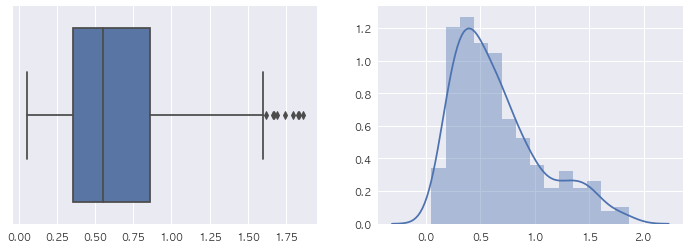

In [209]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4) 

sns.boxplot(buy_category3[["correlation"]], ax=ax1)
sns.distplot(buy_category3[["correlation"]], ax=ax2)

In [227]:
buy_category3.sort_values('correlation', ascending=False).tail(100).big_cat.value_counts()

식품       57
뷰티       40
냉난방가전     3
Name: big_cat, dtype: int64

In [225]:
buy_category3.sort_values('correlation', ascending=False).tail(100)

,big_cat,sm_cat,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,correlation
112,식품,메추리알,0.076429,0.006989,0.104108,0.084339,0.020008,0.062571,0.354445
327,식품,한우육,0.063707,0.024712,0.189018,0.027011,0.022272,0.027701,0.354421
220,식품,식혜/수정과,0.129876,0.024044,0.089624,0.068096,0.002470,0.038488,0.352598
136,식품,반찬류,0.036671,0.050383,0.169442,0.039266,0.008795,0.047649,0.352205
337,뷰티,헤어무스,0.136896,0.020918,0.068627,0.091884,0.014143,0.018339,0.350807
305,뷰티,클렌징 폼,0.095886,0.040848,0.137782,0.032920,0.032299,0.008745,0.348481
222,식품,쌀,0.157329,0.040384,0.041376,0.041568,0.019392,0.045151,0.345200
189,식품,생닭/닭부분육,0.052345,0.040694,0.150044,0.019935,0.017385,0.064520,0.344924
168,뷰티,뷰티용 샤프너,0.115436,0.000343,0.086057,0.084276,0.033253,0.024279,0.343644
69,식품,낙지,0.087452,0.035066,0.106599,0.042427,0.011861,0.058977,0.342383


In [210]:
buy_category3.describe()

,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,correlation
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,0.249870,0.065854,0.080325,0.118320,0.085571,0.054952,0.654891
std,0.204447,0.055696,0.053475,0.093951,0.073784,0.041940,0.398753
min,0.001421,0.000029,0.000666,0.001224,0.000319,0.000730,0.050317
25%,0.086267,0.020545,0.036780,0.042375,0.023711,0.021595,0.351506
50%,0.188603,0.049055,0.072902,0.093782,0.069420,0.045784,0.549655
75%,0.366753,0.101640,0.114823,0.179307,0.124436,0.076340,0.856828
max,0.819175,0.290211,0.254873,0.556420,0.343261,0.189992,1.866211


In [216]:
buy_category3[buy_category3["correlation"] > 0.6].shape

(176, 9)

In [211]:
buy_category3[buy_category3["correlation"] > 0.6].big_cat.value_counts()

식품       85
뷰티       61
냉난방가전    30
Name: big_cat, dtype: int64

## 4. NaN 제외하고 체크하기 

In [247]:
def weather_correlation4(weather, product, loc) : 
    df1 = weather[weather.지역 == loc].reset_index(drop=True)
    df2 = buy[buy.sm_cat == product]
    df = df1.merge(df2, on="date", how='right')
    df['sm_cat'] = df['sm_cat'].fillna(product) # ; df['qty'] = df['qty'].fillna(0)
    co = dict(np.abs(df.corr(method='spearman')["qty"][:-1]))
    co["category"] = product
    return co

In [249]:
result4 = pd.DataFrame()

for cat in tqdm(buy.sm_cat.unique()) : 
    result4 = result4.append(pd.DataFrame(weather_correlation3(weather2, cat, '서울'), index=[0]), ignore_index=True)
    
buy_category4 = buy_full[["big_cat", 'sm_cat']].drop_duplicates().reset_index(drop=True)
buy_category4 = buy_category4.merge(result4, left_on='sm_cat', right_on="category", how='left')
buy_category4 = buy_category4.drop('category', axis=1)

# score 
buy_category4["score"] = buy_category4.loc[:,list(buy_category4.columns)[2:]].sum(axis=1)

100%|██████████| 383/383 [00:07<00:00, 49.68it/s]


In [256]:
buy_category4 = buy_category4.sort_values('score', ascending=False).reset_index(drop=True)

In [259]:
buy_category4[buy_category4.sm_cat == "중대형 에어컨"]

,big_cat,sm_cat,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,score
305,냉난방가전,중대형 에어컨,0.166337,0.018906,0.055741,0.013631,0.016562,0.039387,0.310564


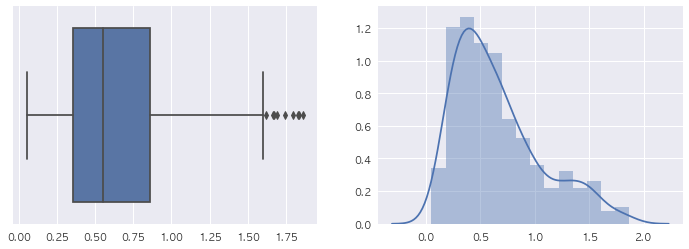

In [269]:
figure, (ax1, ax2) = plt.subplots(ncols=2)
figure.set_size_inches(12,4) 

sns.boxplot(buy_category4[["score"]], ax=ax1)
sns.distplot(buy_category4[["score"]], ax=ax2)

In [266]:
buy_category4.describe()

,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,score
count,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000,383.000000
mean,0.249870,0.065854,0.080325,0.118320,0.085571,0.054952,0.654891
std,0.204447,0.055696,0.053475,0.093951,0.073784,0.041940,0.398753
min,0.001421,0.000029,0.000666,0.001224,0.000319,0.000730,0.050317
25%,0.086267,0.020545,0.036780,0.042375,0.023711,0.021595,0.351506
50%,0.188603,0.049055,0.072902,0.093782,0.069420,0.045784,0.549655
75%,0.366753,0.101640,0.114823,0.179307,0.124436,0.076340,0.856828
max,0.819175,0.290211,0.254873,0.556420,0.343261,0.189992,1.866211


# Data Save 

In [270]:
final = buy_category4[buy_category4.score >= 0.549655]
print(final.shape)

final.big_cat.value_counts()

(192, 9)


식품       94
뷰티       67
냉난방가전    31
Name: big_cat, dtype: int64

In [276]:
final.head(10)

,big_cat,sm_cat,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,score
0,식품,감귤/한라봉/오렌지,0.781819,0.220087,0.143872,0.339007,0.264361,0.117065,1.866211
1,냉난방가전,복합식 가습기,0.799613,0.247738,0.070702,0.335301,0.319788,0.060826,1.833968
2,냉난방가전,초음파식 가습기,0.819175,0.249171,0.057451,0.315716,0.323280,0.062754,1.827546
3,식품,굴 생물,0.778428,0.209510,0.091692,0.335131,0.262712,0.121048,1.798522
4,냉난방가전,에어워셔,0.735215,0.240862,0.080973,0.346412,0.296342,0.042640,1.742445
5,식품,해초류,0.709691,0.196477,0.090531,0.358012,0.272941,0.068113,1.695766
6,냉난방가전,업소용 선풍기,0.742508,0.207005,0.060012,0.289943,0.274205,0.101560,1.675233
7,뷰티,뷰티 타투,0.722963,0.177168,0.080317,0.294297,0.263440,0.125605,1.663790
8,뷰티,핸드크림,0.731759,0.193824,0.101470,0.258004,0.245471,0.090728,1.621257
9,식품,코코아/핫초코,0.702257,0.137033,0.157499,0.256525,0.233131,0.113123,1.599569


In [272]:
final.to_csv("ProductFiltering.csv", encoding='cp949', index=False)

In [273]:
steady = buy_category4[buy_category4.score < 0.549655]
print(steady.shape)

steady.big_cat.value_counts()

(191, 9)


식품       118
뷰티        64
냉난방가전      9
Name: big_cat, dtype: int64

In [277]:
steady.tail(10)

,big_cat,sm_cat,평균기온,일별강수량,평균풍속,PM10,1시간최대습도,일조시간합,score
373,식품,초유 영양제,0.003866,0.000818,0.095187,0.048225,0.002207,0.008019,0.158322
374,뷰티,헤어스타일링용 염색약,0.003490,0.001669,0.090397,0.020878,0.002891,0.033430,0.152755
375,뷰티,기능성 모공관리 화장품,0.017883,0.019398,0.063467,0.030491,0.011680,0.005286,0.148206
376,식품,구이/수육용 돈육,0.037680,0.013106,0.043447,0.030809,0.005539,0.016087,0.146667
377,식품,견과류 피스타치오,0.040425,0.000378,0.024494,0.053063,0.012589,0.015296,0.146244
378,식품,과일채소 분말/분태,0.030214,0.019582,0.030182,0.008601,0.016245,0.039444,0.144268
379,뷰티,여성향수,0.041540,0.013860,0.010850,0.029854,0.039059,0.007472,0.142636
380,뷰티,기능성 화이트닝 화장품,0.003378,0.033227,0.004315,0.017931,0.018073,0.057528,0.134452
381,뷰티,바디 스크럽,0.027283,0.011592,0.020734,0.001563,0.024672,0.009288,0.095132
382,냉난방가전,산림욕기,0.008859,0.001243,0.000666,0.011648,0.005257,0.022644,0.050317


In [275]:
steady.to_csv("SteadySeller.csv", encoding='cp949', index=False)

In [321]:
# adf test
adf = pd.read_csv("adf_res.csv", encoding="cp949")
print(adf.shape)
adf.head()

(383, 3)


,Unnamed: 0,sm_cat,test_res
0,0,가공란,정상
1,0,가스온수기,정상
2,0,가열식 가습기,비정상
3,0,가자미,정상
4,0,갈비/찜/바비큐용 돈육,비정상


In [323]:
adf_0 = adf[adf["test_res"] == "비정상"]  # 비정상 
adf_1 = adf[adf["test_res"] == "정상"]  # 정상 

adf_0.shape, adf_1.shape

((154, 3), (229, 3))

In [324]:
corr0 = buy_category4[buy_category4.sm_cat.isin(adf_0.sm_cat.unique())]
corr1 = buy_category4[buy_category4.sm_cat.isin(adf_1.sm_cat.unique())]

In [325]:
corr0 = corr0.drop('일조시간합', axis=1) ; corr1 = corr1.drop('일조시간합', axis=1)

In [294]:
# CASE1 : MEDIAN 
# 비정상 
corr0_high = corr0[(corr0.평균기온 >= 0.188603) | (corr0.일별강수량 >= 0.049055) | (corr0.평균풍속 >= 0.072902) | (corr0.PM10 >= 0.093782) | (corr0['1시간최대습도'] >= 0.069420) ]
corr0_low = corr0[~corr0.sm_cat.isin(corr0_high.sm_cat.unique())]

corr0_high.shape, corr0_low.shape

((200, 8), (8, 8))

In [295]:
# 정상 
corr1_high = corr1[(corr1.평균기온 >= 0.188603) | (corr1.일별강수량 >= 0.049055) | (corr1.평균풍속 >= 0.072902) | (corr1.PM10 >= 0.093782) | (corr1['1시간최대습도'] >= 0.069420) ]
corr1_low = corr1[~corr1.sm_cat.isin(corr1_high.sm_cat.unique())]

corr1_high.shape, corr1_low.shape

((139, 8), (36, 8))

In [296]:
# CASE2 : MEAN 
# 비정상 
corr0_high = corr0[(corr0.평균기온 >= 0.249870) | (corr0.일별강수량 >= 0.065854) | (corr0.평균풍속 >= 0.080325) | (corr0.PM10 >= 0.118320) | (corr0['1시간최대습도'] >= 0.085571)]
corr0_low = corr0[~corr0.sm_cat.isin(corr0_high.sm_cat.unique())]

corr0_high.shape, corr0_low.shape

((192, 8), (16, 8))

In [297]:
# 정상 
corr1_high = corr1[(corr1.평균기온 >= 0.249870) | (corr1.일별강수량 >= 0.065854) | (corr1.평균풍속 >= 0.080325) | (corr1.PM10 >= 0.118320) | (corr1['1시간최대습도'] >= 0.085571) ]
corr1_low = corr1[~corr1.sm_cat.isin(corr1_high.sm_cat.unique())]

corr1_high.shape, corr1_low.shape

((121, 8), (54, 8))

In [326]:
# CASE3 : Q3 
# 비정상 
corr0_high = corr0[(corr0.평균기온 >= 0.188603) | (corr0.일별강수량 >= 0.101640) | (corr0.평균풍속 >= 0.114823) | (corr0.PM10 >= 0.179307) | (corr0['1시간최대습도'] >= 0.124436)]
corr0_low = corr0[~corr0.sm_cat.isin(corr0_high.sm_cat.unique())]

corr0_high.shape, corr0_low.shape

((134, 8), (20, 8))

In [327]:
# 정상 
corr1_high = corr1[(corr1.평균기온 >= 0.188603) | (corr1.일별강수량 >= 0.101640) | (corr1.평균풍속 >= 0.114823) | (corr1.PM10 >= 0.179307) | (corr1['1시간최대습도'] >= 0.124436) ]
corr1_low = corr1[~corr1.sm_cat.isin(corr1_high.sm_cat.unique())]

corr1_high.shape, corr1_low.shape

((130, 8), (99, 8))

In [328]:
corr0_high["group"] = "비정상_high" ; corr0_low["group"] = "비정상_low"
corr1_high["group"] = "정상_high" ; corr1_low["group"] = "정상_low"

In [329]:
corr_result = pd.concat([corr0_high, corr0_low, corr1_high, corr1_low], axis=0)

In [330]:
corr_result = corr_result.sort_index()
corr_result = corr_result[["big_cat", "sm_cat", "group"]]

In [331]:
corr_result.to_csv("adf_corr_group_0617.csv", index=False, encoding="cp949")

In [332]:
corr_result.group.value_counts()

비정상_high    134
정상_high     130
정상_low       99
비정상_low      20
Name: group, dtype: int64

In [ ]:
# median 기준으로 이거보다 높으면 살리는 방향으로 